
# Compare model with Todd's

In [26]:
# Load the Keras NN from the h5 and json config files
# Open the file with uproot
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
from tensorflow import keras
from keras.models import model_from_json
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import uproot
import csv
import awkward
import tools
from tqdm import tqdm
import pandas as pd

architecture_filepath = "models/architecture_same_filters.json"
weights_filepath = "models/weights_same_filters.h5"
scale_filepath = "models/scaling_parameters_same_filters_3tags_only_v2.csv"

scale_df = pd.read_csv(scale_filepath)
scale_df_callum = pd.read_csv('csv_callum.csv')

#print()

#for name, _ in scale_df.iteritems():
#    print(name)
#    print(scale_df[name] - scale_df_callum[name])
#    print()

with open(scale_filepath, 'r') as csvf:
    csv_text = csvf.read()

with open('csv_callum.csv', 'r') as csvf:
    csv_text_callum = csvf.read()

print("Do the scaling parameters match?", csv_text == csv_text_callum)

data_filepath = "user.jagrundy.20736236._000001.MiniNTuple.root" 



Do the scaling parameters match? True


In [10]:
# First, read the csv to get the offsets and scales for each input
offset = {"pt":[],"eta":[],"phi":[]}
scale  = {"pt":[],"eta":[],"phi":[]}
with open(scale_filepath, 'r') as csvfile:
    scale_reader = csv.reader(csvfile, delimiter=",")
    row_count=0
    for row in scale_reader:
        if row_count < 4:
            row_count+=1
            continue
        offset["pt"].append(-float(row[0])) 
        offset["eta"].append(-float(row[2])) 
        offset["phi"].append(-float(row[4])) 
        scale["pt"].append(1/np.sqrt(float(row[1])))
        scale["eta"].append(1/np.sqrt(float(row[3])))
        scale["phi"].append(1/np.sqrt(float(row[5])))

# Horribly inefficient, but whatever, it's meant to be a quick check
events = uproot.open(data_filepath)["XhhMiniNtuple"]

# we agree on total number of events here, which is positive!
print(len(events.array('resolvedJets_pt')), 'total events')

777150 total events


In [11]:

#make sure to sort by tag first!
branches = events.arrays(branches=[
        'resolvedJets_pt', 'resolvedJets_eta', 'resolvedJets_phi',
        'resolvedJets_is_DL1r_FixedCutBEff_77', 'resolvedJets_HadronConeExclTruthLabelID'], namedecode='utf-8')
table = awkward.Table(branches)
indices = table["resolvedJets_is_DL1r_FixedCutBEff_77"].argsort()
s_table = awkward.Table()
for label in ['resolvedJets_pt', 'resolvedJets_eta', 'resolvedJets_phi',
              'resolvedJets_is_DL1r_FixedCutBEff_77', 'resolvedJets_HadronConeExclTruthLabelID']:
    s_table[label] = table[label][indices]


nn_inputs = []
event_tags = []
event_truths = []
event_count=0
for pts,etas,phis,tags,truths in tqdm(zip(
                              s_table["resolvedJets_pt"],
                              s_table["resolvedJets_eta"],
                              s_table["resolvedJets_phi"],
                              s_table["resolvedJets_is_DL1r_FixedCutBEff_77"],
                              s_table["resolvedJets_HadronConeExclTruthLabelID"])):

    # Only consider 3-tag events
    if sum(tags) != 3:
        continue

    # Loop over all the untagged jets in the event, up to 7, and save the scaled pt,eta,phi
    event_pts,event_etas,event_phis = [],[],[]
    notag_i = 0
    for i in range(len(tags)):
        if not tags[i]:
            event_pts.append((pts[i] + offset["pt"][notag_i]) * scale["pt"][notag_i])
            event_etas.append((etas[i] + offset["eta"][notag_i]) * scale["eta"][notag_i])
            event_phis.append((phis[i] + offset["phi"][notag_i]) * scale["phi"][notag_i])
            notag_i += 1
        if notag_i == 7: 
            break
    # If we ended up with less than 7 jets, do zero-padding
    while notag_i < 7:
        event_pts.append(offset["pt"][notag_i]*scale["pt"][notag_i])
        event_etas.append(offset["eta"][notag_i]*scale["eta"][notag_i])
        event_phis.append(offset["phi"][notag_i]*scale["phi"][notag_i])
        notag_i += 1
    nn_inputs.append(np.array(event_pts+event_etas+event_phis))
    event_tags.append(tags)
    event_truths.append(truths)

    # Only do the first few events for testing
    #if event_count == 3:
    #    break
    event_count+=1

# we also agree about the number of events with 3 tags
print()
print(event_count, 'events with 3 tags')


777150it [00:32, 23848.71it/s]
313660 events with 3 tags



In [12]:

nn_inputs = np.array(nn_inputs) # Has to be numpy array, not list



# cast these as arrays and pad too
event_tags = np.array(event_tags)
event_truths = np.array(event_truths) / 5  # by default this is 0 or 5, we want 0 or 1
tag = pad_sequences(event_tags, maxlen=10, padding='post', dtype=int, value = 0)
truth = pad_sequences(event_truths, maxlen=10, padding='post', dtype=int, value = 0)


# Load and run the model
model = model_from_json(open(architecture_filepath,'r').read())
model.load_weights(weights_filepath)
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 21)                462       
_________________________________________________________________
dense_9 (Dense)              (None, 700)               15400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 700)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 500)               350500    
_________________________________________________________________
dropout_2 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 300)               150300    
_________________________________________________________________
dropout_3 (Dropout)          (None, 300)              

testing inputs
testing scores
0
[1 1 1 0 0 0 0 0 0 0]
[1 1 1 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]

1
[1 1 1 0 0 0 0 0 0 0]
[1 1 1 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]

2
[1 1 1 0 0 0 0 0 0 0]
[1 1 1 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]

3
[1 1 1 0 0 0 0 0 0 0]
[1 1 1 0 0 0 0 0 0 0]
[0 0 0 1 0 0 0 0 0 0]

4
[1 1 1 0 0 0 0 0 0 0]
[1 1 1 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]

5
[1 1 1 0 0 0 0 0 0 0]
[1 1 1 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]

6
[1 1 1 0 0 0 0 0 0 0]
[1 1 1 0 0 0 0 0 0 0]
[0 0 0 1 0 0 0 0 0 0]

7
[1 1 1 0 0 0 0 0 0 0]
[1 1 1 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]

8
[1 1 1 0 0 0 0 0 0 0]
[1 1 1 1 0 0 0 0 0 0]
[0 0 0 1 0 0 0 0 0 0]

9
[1 1 1 0 0 0 0 0 0 0]
[1 1 1 1 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]

100%|██████████| 313660/313660 [00:04<00:00, 66621.20it/s]
overall accuracy: 46.22 percent
ignoring 2.62 percent (8206 events) of 313660 events


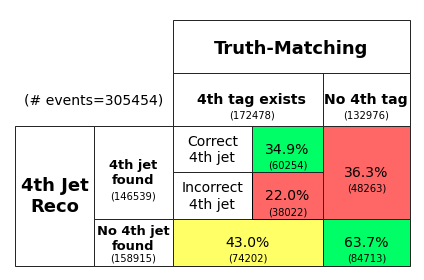

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [25]:

nn_inputs_callum = np.load('nn_inputs_callum.npy')

input_tolerance = 1e-5
output_tolerance = 1e-4

print('testing inputs')
for i in range(len(nn_inputs)):
    for j in range(len(nn_inputs[i])):
        diff = nn_inputs[i][j] - nn_inputs_callum[i][j]
        if diff > input_tolerance:
            print(i, j)
            print(nn_inputs[i][j])
            print(nn_inputs_callum[i][j])
            print(nn_inputs[i][j] - nn_inputs_callum[i][j])
            print()
            raise ValueError('inputs too different')

scores = model.predict(nn_inputs)

scores_callum = np.load('scores_callum.npy')

print('testing scores')
for i in range(len(scores)):
    for j in range(len(scores[i])):
        diff = scores[i][j] - scores_callum[i][j]
        if diff > output_tolerance:
            print(i, j)
            print(scores[i][j])
            print(scores_callum[i][j])
            print(scores[i][j] - scores_callum[i][j])
            print()
            raise ValueError('scores too different')

#for i in range(len(nn_inputs)):
#    print("Event",i)
#    print("Inputs",nn_inputs[i])
#    print("Outputs")
#    for j in range(len(scores[i])):
#        print("  ",j,round(scores[i][j],4))
#    print("")

# convert nn scores into "selections"
select=np.argmax(scores,axis=-1)
selections = np.zeros((len(scores), len(tag[0])+1), dtype=int)
for i, s in enumerate(select):
    selections[i][s+3] = 1
# chop off the last "no selection" jet
selections = selections[:,:-1]

for i in range(10):
    print(i)
    print(tag[i])
    print(truth[i])
    print(selections[i])
    print()

import importlib
importlib.reload(tools)
tools.evaluate_model(truth, tag, selections)